In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import dill as pk

In [2]:
df = pd.read_csv('Data/INFY.NS-train.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-01,436.500000,437.375000,432.756256,433.500000,339.445984,1478688
1,2014-01-02,432.906250,438.500000,432.906250,435.068756,340.674377,4404744
2,2014-01-03,434.375000,446.875000,431.781250,445.643738,348.954987,10046344
3,2014-01-06,446.887512,447.562500,433.575012,439.737488,344.330170,11098328
4,2014-01-07,439.881256,440.737488,430.837494,432.143738,338.384003,7713688


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2220 non-null   object 
 1   Open       2220 non-null   float64
 2   High       2220 non-null   float64
 3   Low        2220 non-null   float64
 4   Close      2220 non-null   float64
 5   Adj Close  2220 non-null   float64
 6   Volume     2220 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 121.5+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

<Axes: xlabel='Date', ylabel='Close'>

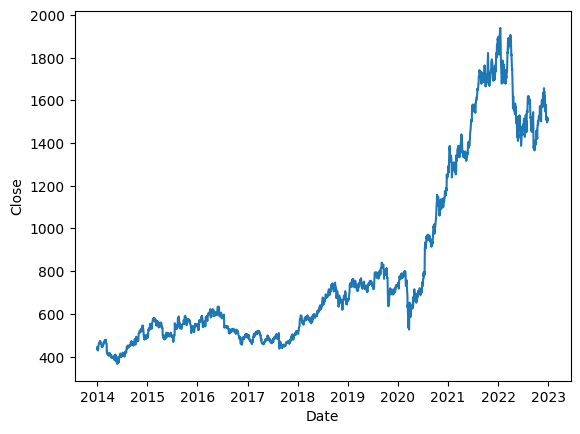

In [5]:
sns.lineplot(x='Date', y='Close', data=df)

In [6]:
df = df[['Date', 'Close']]

In [7]:
df.head()

,Date,Close
0,2014-01-01,433.500000
1,2014-01-02,435.068756
2,2014-01-03,445.643738
3,2014-01-06,439.737488
4,2014-01-07,432.143738


In [8]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2014-01-10,443.906250,431.350006,428.512512,432.143738,439.737488,445.643738,435.068756,433.500000
2014-01-13,458.125000,443.906250,431.350006,428.512512,432.143738,439.737488,445.643738,435.068756
2014-01-14,460.843750,458.125000,443.906250,431.350006,428.512512,432.143738,439.737488,445.643738
2014-01-15,464.006256,460.843750,458.125000,443.906250,431.350006,428.512512,432.143738,439.737488
2014-01-16,465.631256,464.006256,460.843750,458.125000,443.906250,431.350006,428.512512,432.143738


In [9]:
shifted_df_to_np = shifted_df.to_numpy()
shifted_df_to_np

array([[ 443.90625   ,  431.3500061 ,  428.51251221, ...,  445.64373779,
         435.0687561 ,  433.5       ],
       [ 458.125     ,  443.90625   ,  431.3500061 , ...,  439.73748779,
         445.64373779,  435.0687561 ],
       [ 460.84375   ,  458.125     ,  443.90625   , ...,  432.14373779,
         439.73748779,  445.64373779],
       ...,
       [1510.15002441, 1514.84997559, 1502.40002441, ..., 1509.55004883,
        1507.30004883, 1507.34997559],
       [1517.55004883, 1510.15002441, 1514.84997559, ..., 1522.05004883,
        1509.55004883, 1507.30004883],
       [1508.19995117, 1517.55004883, 1510.15002441, ..., 1497.09997559,
        1522.05004883, 1509.55004883]])

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_to_np = scaler.fit_transform(shifted_df_to_np)

shifted_df_to_np

array([[-0.90044872, -0.91640392, -0.92000951, ..., -0.89824089,
        -0.91167851, -0.91367192],
       [-0.88238097, -0.90044872, -0.91640392, ..., -0.90574596,
        -0.89824089, -0.91167851],
       [-0.87892626, -0.88238097, -0.90044872, ..., -0.91539532,
        -0.90574596, -0.89824089],
       ...,
       [ 0.45442564,  0.46039786,  0.44457772, ...,  0.45366325,
         0.45080418,  0.45086762],
       [ 0.46382884,  0.45442564,  0.46039786, ...,  0.46954698,
         0.45366325,  0.45080418],
       [ 0.45194768,  0.46382884,  0.45442564, ...,  0.43784296,
         0.46954698,  0.45366325]])

In [11]:
X = shifted_df_to_np[:, 1:]
y = shifted_df_to_np[:, 0]

In [12]:
X.shape, y.shape

((2213, 7), (2213,))

In [13]:
X = dc(np.flip(X, axis=1))

In [14]:
X

array([[-0.91367192, -0.91167851, -0.89824089, ..., -0.91539532,
        -0.92000951, -0.91640392],
       [-0.91167851, -0.89824089, -0.90574596, ..., -0.92000951,
        -0.91640392, -0.90044872],
       [-0.89824089, -0.90574596, -0.91539532, ..., -0.91640392,
        -0.90044872, -0.88238097],
       ...,
       [ 0.45086762,  0.45080418,  0.45366325, ...,  0.43784296,
         0.44457772,  0.46039786],
       [ 0.45080418,  0.45366325,  0.46954698, ...,  0.44457772,
         0.46039786,  0.45442564],
       [ 0.45366325,  0.46954698,  0.43784296, ...,  0.46039786,
         0.45442564,  0.46382884]])

In [15]:
df_test = pd.read_csv('Data/INFY.NS-test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_test = df_test[['Date', 'Close']]

lookback = 7
shifted_df_test = prepare_dataframe_for_lstm(df_test, lookback)

shifted_df_test_to_np = shifted_df_test.to_numpy()
shifted_df_test_to_np = scaler.fit_transform(shifted_df_test_to_np)

X_test = shifted_df_test_to_np[:, 1:]
y_test = shifted_df_test_to_np[:, 0]

X_test = dc(np.flip(X_test, axis=1))

In [16]:
x_train = X
y_train = y

x_test = X_test
y_test = y_test

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2213, 7), (2213,), (238, 7), (238,))

In [17]:
x_train = x_train.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2213, 7, 1), (2213, 1), (238, 7, 1), (238, 1))

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
x_train = torch.tensor(x_train).to(dtype=torch.float)
x_test = torch.tensor(x_test).to(dtype=torch.float)
y_train = torch.tensor(y_train).to(dtype=torch.float)
y_test = torch.tensor(y_test).to(dtype=torch.float)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([2213, 7, 1]),
 torch.Size([2213, 1]),
 torch.Size([238, 7, 1]),
 torch.Size([238, 1]))

In [20]:
from torch.utils.data import Dataset

class StockPredictorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = StockPredictorDataset(x_train, y_train)
test_dataset = StockPredictorDataset(x_test, y_test)

In [21]:
print(train_dataset[0])

(tensor([[-0.9137],
        [-0.9117],
        [-0.8982],
        [-0.9057],
        [-0.9154],
        [-0.9200],
        [-0.9164]]), tensor([-0.9004]))


In [22]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
device = 'cuda:0'

In [68]:
torch.manual_seed(1)

lstm = nn.LSTM(3, 3,1)  # Input dim is 3, output dim is 3
lstm2 = nn.LSTM(3, 3,1)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.zeros(1, 1, 3),
          torch.zeros(1, 1, 3))

idx=0
for i in inputs:
    print(f'idx: {idx}')
    idx+=1
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    print(out)
    out, hidden = lstm2(out, hidden)
    print(out)
    print("==========")

idx: 0
tensor([[[ 0.0999, -0.2939,  0.0006]]], grad_fn=<MkldnnRnnLayerBackward0>)
tensor([[[ 0.0130, -0.0119,  0.0765]]], grad_fn=<MkldnnRnnLayerBackward0>)
idx: 1
tensor([[[-0.0617,  0.0263,  0.0328]]], grad_fn=<MkldnnRnnLayerBackward0>)
tensor([[[-0.0588,  0.0191,  0.0988]]], grad_fn=<MkldnnRnnLayerBackward0>)
idx: 2
tensor([[[-0.0772,  0.0416,  0.0203]]], grad_fn=<MkldnnRnnLayerBackward0>)
tensor([[[-0.0798,  0.0261,  0.0877]]], grad_fn=<MkldnnRnnLayerBackward0>)
idx: 3
tensor([[[-0.2819,  0.0521,  0.1257]]], grad_fn=<MkldnnRnnLayerBackward0>)
tensor([[[-0.1359,  0.0081,  0.1523]]], grad_fn=<MkldnnRnnLayerBackward0>)
idx: 4
tensor([[[-0.2582, -0.2629,  0.0599]]], grad_fn=<MkldnnRnnLayerBackward0>)
tensor([[[-0.1171, -0.0541,  0.1915]]], grad_fn=<MkldnnRnnLayerBackward0>)


In [99]:
class LSTM_Stock(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        self.LSTM1= nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, num_layers=num_stacked_layers, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size=self.hidden_size, hidden_size=hidden_size, num_layers=num_stacked_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        hidden = (h0, c0)
        out, hidden = self.LSTM1(x, hidden)
        out, _ = self.LSTM2(out, hidden)
        out = self.fc1(out[:, -1, :])

        return out
    
model = LSTM_Stock(1, 20, 10)
model.to(device)
model

LSTM_Stock(
  (LSTM1): LSTM(1, 20, num_layers=10, batch_first=True)
  (LSTM2): LSTM(20, 20, num_layers=10, batch_first=True)
  (fc1): Linear(in_features=20, out_features=1, bias=True)
)

In [42]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_fun(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_index % 100 == 99:
            avg_loss = running_loss / 100
            print(f'Batch: {batch_index + 1}, Loss: {avg_loss}')
            
            running_loss = 0
    print()

In [43]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_fun(output, y_batch)
            running_loss += loss.item()
            
    avg_loss = running_loss / len(test_loader)
    
    print(f'Validation loss: {avg_loss}')
    print('****************************')
    print()

In [100]:
learning_rate = 0.001
num_epochs = 10
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch: 100, Loss: 0.30481503158807755

Validation loss: 0.16734053691228232
****************************

Epoch: 2
Batch: 100, Loss: 0.028526945875491948

Validation loss: 0.11051920118431251
****************************

Epoch: 3
Batch: 100, Loss: 0.014123577915597707

Validation loss: 0.09488695835073789
****************************

Epoch: 4
Batch: 100, Loss: 0.01238883490092121

Validation loss: 0.10392420229812463
****************************

Epoch: 5
Batch: 100, Loss: 0.013296196535229683

Validation loss: 0.10579447268197933
****************************

Epoch: 6
Batch: 100, Loss: 0.010374542482895776

Validation loss: 0.07984057081242403
****************************

Epoch: 7
Batch: 100, Loss: 0.005214656579773873

Validation loss: 0.07754250677923362
****************************

Epoch: 8
Batch: 100, Loss: 0.0032775668893009423

Validation loss: 0.07666199350108703
****************************

Epoch: 9
Batch: 100, Loss: 0.003136288310633972

Validation loss: 0.08064

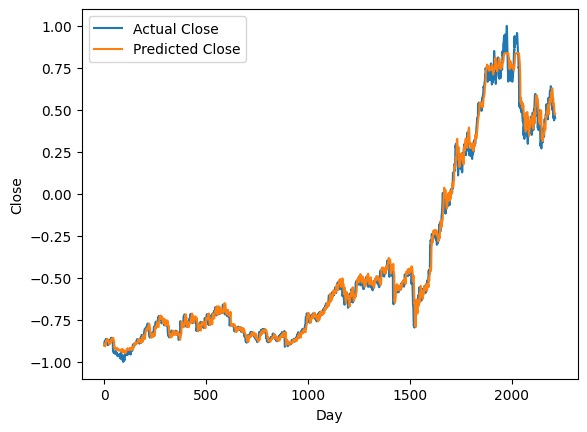

In [101]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()
    
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

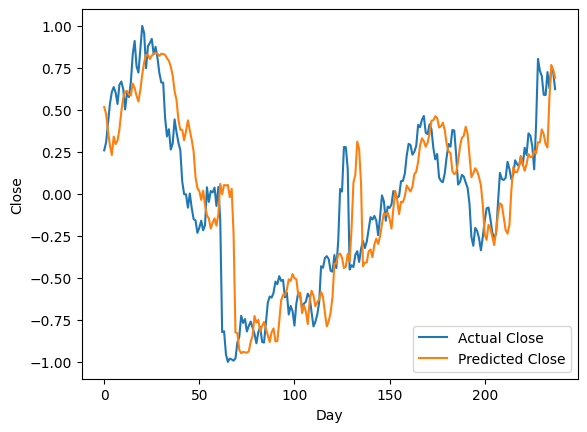

In [102]:
predicted = model(x_test.to(device)).detach().to('cpu').numpy().flatten()
    
plt.plot(y_test, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [103]:
from sklearn.metrics import mean_squared_error

# y_test = y_test.numpy().flatten()
print(mean_squared_error(y_test, predicted))

0.079330415


In [31]:
# with open('Models/INFY.NS.pt', 'wb') as file:
#     pk.dump(model, file)